In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
!pip install pandas numpy matplotlib scikit-learn statsmodels prophet pyspark


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Rows, columns: (52696, 21)
date        datetime64[ns]
p                  float64
T                  float64
Tpot               float64
Tdew               float64
rh                 float64
VPmax              float64
VPact              float64
VPdef              float64
sh                 float64
H2OC               float64
rho                float64
wv                 float64
max. wv            float64
wd                 float64
rain               float64
raining            float64
SWDR               float64
PAR                float64
max. PAR           float64
Tlog               float64
dtype: object
date        0
p           0
T           0
Tpot        0
Tdew        0
rh          0
VPmax       0
VPact       0
VPdef       0
sh          0
H2OC        0
rho         0
wv          0
max. wv     0
wd          0
rain        0
raining     0
SWDR        0
PAR         0
max. PAR    0
Tlog        0
dtype: int64
                                date             p             T  \
count            

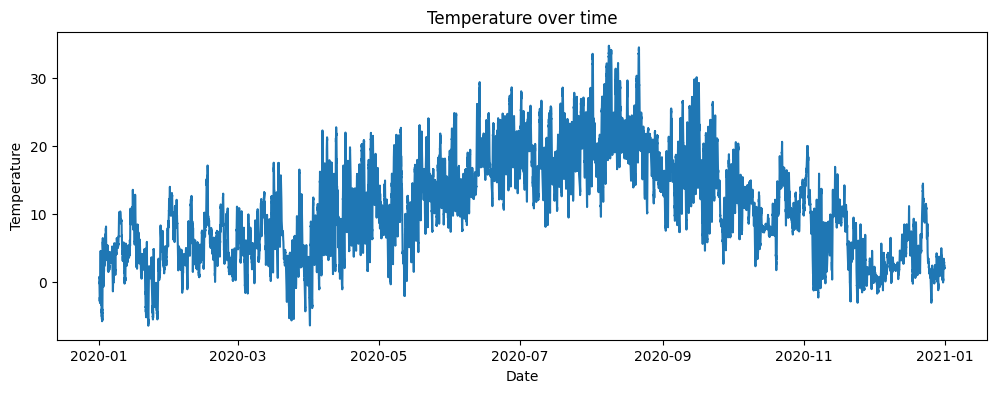

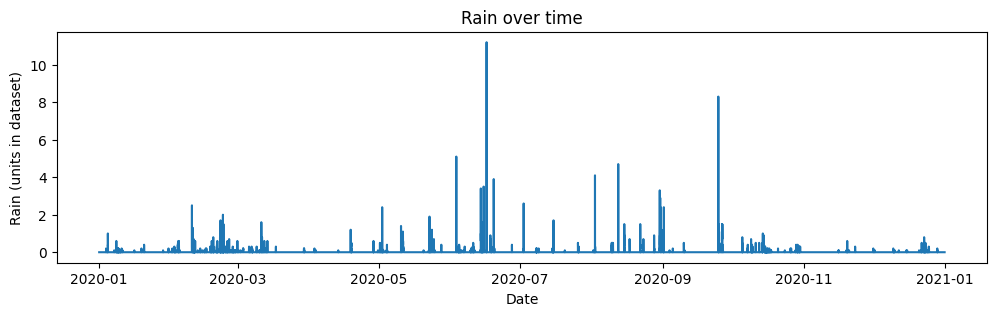

Daily sample:
        date         T  rain
0 2020-01-01 -0.514196   0.0
1 2020-01-02 -1.056319   0.0
2 2020-01-03  4.835278   0.3
3 2020-01-04  3.784931   4.8
4 2020-01-05  2.735000   0.0
rain        1.000000
raining     0.409280
rh          0.087426
sh          0.075156
H2OC        0.075122
VPact       0.073675
Tdew        0.069465
max. wv     0.030935
wd          0.029619
Tpot        0.015404
Tlog        0.011637
T           0.008448
wv          0.001096
VPmax      -0.001426
rho        -0.034599
max. PAR   -0.036056
PAR        -0.041945
SWDR       -0.043420
VPdef      -0.055481
p          -0.071890
Name: rain, dtype: float64


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = path = r"C:\Users\harsh\Downloads\archive.zip"
df = pd.read_csv(path, parse_dates=["date"], dayfirst=False)  
df = df.sort_values("date").reset_index(drop=True)

print("Rows, columns:", df.shape)
print(df.dtypes)
print(df.isnull().sum())

print(df.describe(include="all"))

print("Date range:", df['date'].min(), "to", df['date'].max())

plt.figure(figsize=(12,4))
plt.plot(df['date'], df['T'])
plt.title("Temperature over time")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(df['date'], df['rain'])
plt.title("Rain over time")
plt.xlabel("Date")
plt.ylabel("Rain (units in dataset)")
plt.show()

df_daily = df.set_index('date').resample('D').agg({
    'T': 'mean',
    'rain': 'sum',
}).reset_index()

print("Daily sample:")
print(df_daily.head())

df_daily[['T','rain']] = df_daily[['T','rain']].ffill().bfill()

num = df.select_dtypes(include=[np.number])
corr = num.corr()
print(corr['rain'].sort_values(ascending=False))  

df_daily.to_csv(r"C:\Users\harsh\Downloads\cleaned_weather_daily.csv", index=False)

In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\harsh\Downloads\cleaned_weather_daily.csv", parse_dates=["date"]).set_index("date")

for lag in [1,2,3,7,14,30]:
    df[f"T_lag_{lag}"] = df['T'].shift(lag)
    df[f"rain_lag_{lag}"] = df['rain'].shift(lag)

df['T_roll7_mean'] = df['T'].rolling(7).mean()
df['rain_roll7_sum'] = df['rain'].rolling(7).sum()

df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day
df['year'] = df.index.year
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

df_model = df.dropna().copy()

df_model.to_csv(r"C:\Users\harsh\Downloads\for_modeling.csv", index=True)
print("Modeling dataset shape:", df_model.shape)

Modeling dataset shape: (337, 21)


In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

df = pd.read_csv(r"C:\Users\harsh\Downloads\for_modeling.csv", parse_dates=["date"], index_col="date")

df['T_next'] = df['T'].shift(-1)
df = df.dropna()

train = df[:int(0.8*len(df))]
test = df[int(0.8*len(df)):]

features = [c for c in df.columns if c.startswith('T_lag_') or c.startswith('rain_lag_') or c.startswith('T_roll') or c in ['dayofweek','month','is_weekend']]

X_train, y_train = train[features], train['T_next']
X_test, y_test = test[features], test['T_next']

y_pred_persist = X_test['T_lag_1'].values
print("Persistence RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_persist)))

lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear MAE:", mean_absolute_error(y_test, y_pred_lr))

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RF RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


Persistence RMSE: 3.47001264450737
Linear RMSE: 3.4123035127862025
Linear MAE: 2.6677861819803925
RF RMSE: 4.948855552908575


In [12]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

df = pd.read_csv(r"C:\Users\harsh\Downloads\cleaned_weather_daily.csv", parse_dates=["date"], index_col="date")
y = df['T'].asfreq('D')  

train = y[:int(0.8*len(y))]
test = y[int(0.8*len(y)):]

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
pred = res.predict(start=test.index[0], end=test.index[-1])
print("SARIMA RMSE:", np.sqrt(mean_squared_error(test, pred)))

SARIMA RMSE: 6.6165909800708524


In [14]:
from prophet import Prophet
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np

df = pd.read_csv(r"C:\Users\harsh\Downloads\cleaned_weather_daily.csv", parse_dates=["date"])
prophet_df = df[['date','T']].rename(columns={'date':'ds','T':'y'})

train = prophet_df.iloc[:int(0.8*len(prophet_df))]
test = prophet_df.iloc[int(0.8*len(prophet_df)):]

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='D')
fcst = m.predict(future)
fcst_test = fcst.iloc[-len(test):]['yhat'].values

print("Prophet RMSE:", np.sqrt(mean_squared_error(test['y'].values, fcst_test)))

20:00:18 - cmdstanpy - INFO - Chain [1] start processing
20:00:18 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 10.655413611062173


In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("WeatherLongTerm").getOrCreate()

path = r"file:///C:/Users/harsh/Downloads/cleaned_weather_daily.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(path)
df = df.withColumn("date", col("date").cast("timestamp"))

print("Rows:", df.count())

Rows: 367


In [17]:
df.show(5)  

+-------------------+-------------------+-------------------+
|               date|                  T|               rain|
+-------------------+-------------------+-------------------+
|2020-01-01 00:00:00|-0.5141958041958042|                0.0|
|2020-01-02 00:00:00|-1.0563194444444446|                0.0|
|2020-01-03 00:00:00|  4.835277777777778|0.30000000000000004|
|2020-01-04 00:00:00| 3.7849305555555555|                4.8|
|2020-01-05 00:00:00|              2.735|                0.0|
+-------------------+-------------------+-------------------+
only showing top 5 rows


In [18]:
df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- T: double (nullable = true)
 |-- rain: double (nullable = true)



In [19]:
df.describe().show() 

+-------+-------------------+------------------+
|summary|                  T|              rain|
+-------+-------------------+------------------+
|  count|                367|               367|
|   mean| 10.794831933736019|1.6904632152588555|
| stddev|  6.718603842532184| 5.383870015353492|
|    min|-2.7054166666666664|               0.0|
|    max|          26.869375|              46.4|
+-------+-------------------+------------------+



In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, dayofmonth, month, year, dayofweek, lag
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("WeatherAnalysis").getOrCreate()

path = r"file:///C:/Users/harsh/Downloads/cleaned_weather_daily.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(path)
df = df.withColumn("date", col("date").cast("timestamp"))

df = df.withColumn("year", year(col("date"))) \
       .withColumn("month", month(col("date"))) \
       .withColumn("day", dayofmonth(col("date"))) \
       .withColumn("day_of_week", dayofweek(col("date")))

window_spec = Window.orderBy("date")
df = df.withColumn("temp_lag1", lag("T", 1).over(window_spec))

df.show(5)

+-------------------+-------------------+-------------------+----+-----+---+-----------+-------------------+
|               date|                  T|               rain|year|month|day|day_of_week|          temp_lag1|
+-------------------+-------------------+-------------------+----+-----+---+-----------+-------------------+
|2020-01-01 00:00:00|-0.5141958041958042|                0.0|2020|    1|  1|          4|               NULL|
|2020-01-02 00:00:00|-1.0563194444444446|                0.0|2020|    1|  2|          5|-0.5141958041958042|
|2020-01-03 00:00:00|  4.835277777777778|0.30000000000000004|2020|    1|  3|          6|-1.0563194444444446|
|2020-01-04 00:00:00| 3.7849305555555555|                4.8|2020|    1|  4|          7|  4.835277777777778|
|2020-01-05 00:00:00|              2.735|                0.0|2020|    1|  5|          1| 3.7849305555555555|
+-------------------+-------------------+-------------------+----+-----+---+-----------+-------------------+
only showing top 5 

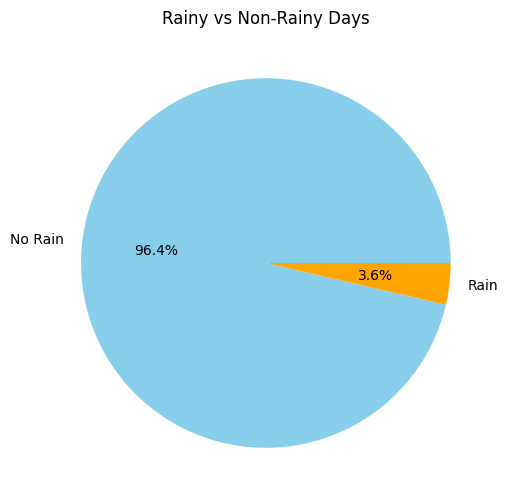

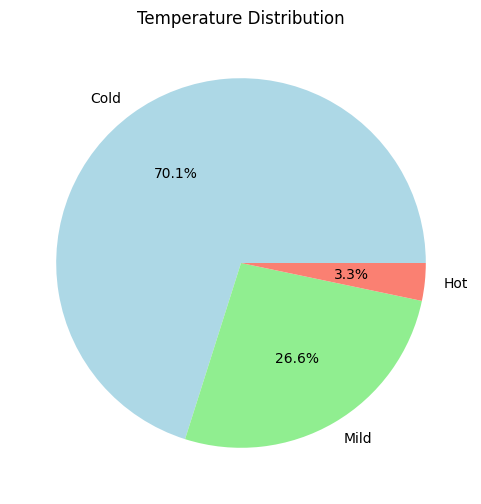

In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("WeatherPrediction").getOrCreate()

df = spark.read.csv("file:///C:/Users/harsh/Downloads/archive", header=True, inferSchema=True)

from pyspark.sql.functions import col, when
df = df.withColumn("rainy", when(col("rain") > 0, 1).otherwise(0))

pdf = df.select("rainy").toPandas()

rain_counts = pdf['rainy'].value_counts()
labels = ['No Rain', 'Rain']
plt.figure(figsize=(6,6))
plt.pie(rain_counts, labels=labels, autopct='%1.1f%%', colors=['skyblue','orange'])
plt.title("Rainy vs Non-Rainy Days")
plt.show()

pdf_temp = df.select("T").toPandas()
conditions = [
    (pdf_temp['T'] < 15),
    (pdf_temp['T'] >= 15) & (pdf_temp['T'] <= 25),
    (pdf_temp['T'] > 25)
]
choices = ['Cold', 'Mild', 'Hot']
pdf_temp['temp_category'] = pd.cut(pdf_temp['T'], bins=[-100,15,25,100], labels=['Cold','Mild','Hot'])

temp_counts = pdf_temp['temp_category'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(temp_counts, labels=temp_counts.index, autopct='%1.1f%%', colors=['lightblue','lightgreen','salmon'])
plt.title("Temperature Distribution")
plt.show()

Saved weather predictions into: C:/Users/harsh/Downloads/final_weather_predictions.csv


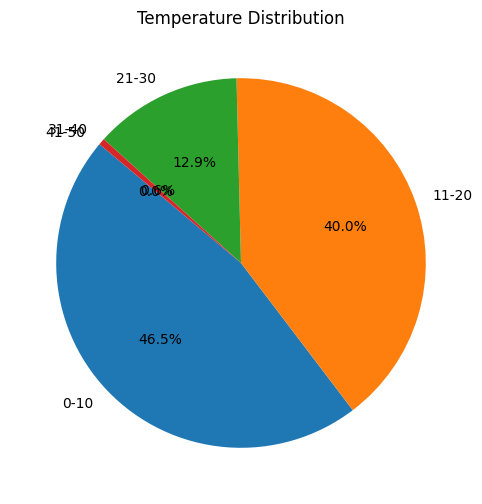

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("WeatherPrediction").getOrCreate()

df = spark.read.csv("file:///C:/Users/harsh/Downloads/archive", header=True, inferSchema=True)

df = df.withColumn("year", year("date")) \
       .withColumn("month", month("date")) \
       .withColumn("day", dayofmonth("date")) \
       .withColumn("day_of_week", dayofweek("date"))

df = df.na.drop(subset=["T"])

feature_cols = ["year", "month", "day", "day_of_week"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df)

lr = LinearRegression(featuresCol="features", labelCol="T")
lr_model = lr.fit(df_features)

lr_predictions = lr_model.transform(df_features)

lr_predictions.select("date", "T", "prediction") \
    .write.csv("file:///C:/Users/harsh/Downloads/final_weather_predictions.csv", 
               header=True, mode="overwrite")

print("Saved weather predictions into: C:/Users/harsh/Downloads/final_weather_predictions.csv")

df_pd = lr_predictions.select("T").toPandas()
bins = [0, 10, 20, 30, 40, 50]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50']
df_pd['temp_range'] = pd.cut(df_pd['T'], bins=bins, labels=labels, include_lowest=True)

pie_data = df_pd['temp_range'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', startangle=140)
plt.title("Temperature Distribution")
plt.show()